In [61]:
from glob import glob
from cv2 import cvtColor
import os as os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import hashlib
import random

## Load images from folder


In [54]:
CLASS_NAMES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

def image_hash(img):
    return hashlib.md5(img.tobytes()).hexdigest()

def load_images_from_folder(folder):
    images = []
    labels = []
    categories = []        # lagrer className for hvert bilde
    image_paths = []       # valgfritt, men kjekt å ha til debugging
    
    hashes = {}            # hash -> index i images
    duplicates = {}        # hash -> liste av {"img": img, "path": path}

    for label, className in enumerate(CLASS_NAMES):
        class_folder = os.path.join(folder, className)
        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            img = cv2.imread(img_path)

            if img is None:
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (128, 128))

            h = image_hash(img)
            rel_path = "/" + os.path.join(className, filename)

            if h in hashes:
                if h not in duplicates:
                    original_idx = hashes[h]
                    duplicates[h] = [{
                        "img": images[original_idx],
                        "path": image_paths[original_idx]
                    }]
                duplicates[h].append({
                    "img": img,
                    "path": rel_path
                })
                continue

            hashes[h] = len(images)
            images.append(img)
            labels.append(label)
            categories.append(className)
            image_paths.append(rel_path)

    return (
        np.array(images, dtype=np.uint8),
        np.array(labels, dtype=np.int64),
        np.array(categories, dtype=object),
        duplicates
    )

In [56]:
X_train, y_train, train_categories, train_duplicates = load_images_from_folder('intel-image-classification/seg_train/seg_train/')
X_test, y_test, categories_test, test_duplicates = load_images_from_folder('intel-image-classification/seg_test/seg_test/')

In [57]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(14019, 128, 128, 3) (14019,)
(3000, 128, 128, 3) (3000,)


In [58]:
print(len(train_duplicates), len(test_duplicates))

15 0


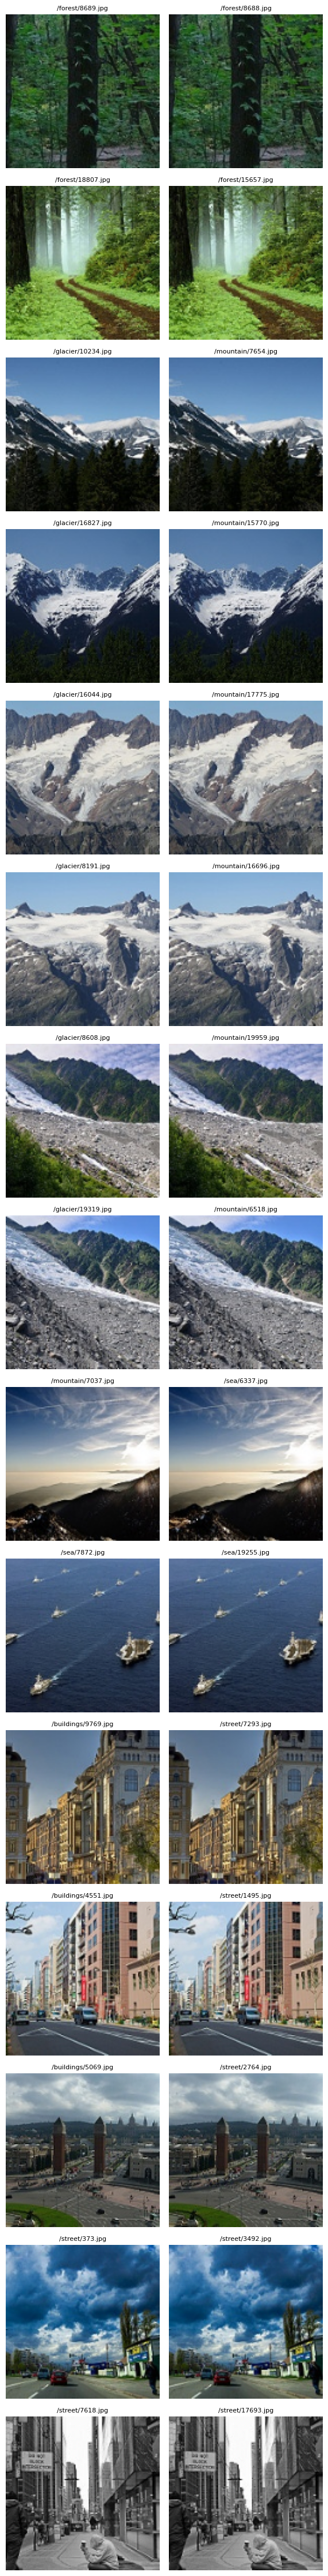

In [59]:
groups = list(train_duplicates.items())
num_groups = len(groups)
if num_groups == 0:
    print("Ingen duplikater.")
else:
    max_len = max(len(img_list) for _, img_list in groups)

    fig, axes = plt.subplots(
        num_groups,
        max_len,
        figsize=(3 * max_len, 3 * num_groups)
    )

    if num_groups == 1 and max_len == 1:
        axes = np.array([[axes]])
    elif num_groups == 1:
        axes = np.array([axes])
    elif max_len == 1:
        axes = axes.reshape(-1, 1)

    for row_idx, (h, img_list) in enumerate(groups):
        for col_idx in range(max_len):
            ax = axes[row_idx, col_idx]

            if col_idx < len(img_list):
                entry = img_list[col_idx]
                img = entry["img"]
                path = entry["path"]

                ax.imshow(img)
                ax.axis('off')
                ax.set_title(path, fontsize=8)
            else:
                ax.axis('off')

        axes[row_idx, 0].set_ylabel(
            f"Hash:\n{h[:8]}...", 
            fontsize=8,
            rotation=0,
            labelpad=40,
            va='center'
        )

    plt.tight_layout()
    plt.show()


In [62]:
random.seed(42)
np.random.seed(42)

def random_horizontal_flip(img):
    return np.fliplr(img)

def random_rotate(img, max_angle=15):
    h, w = img.shape[:2]
    angle = random.uniform(-max_angle, max_angle)
    M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1.0)
    return cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT_101)

def random_resized_crop(img, scale_min=0.8):
    h, w = img.shape[:2]
    scale = random.uniform(scale_min, 1.0)
    nh, nw = int(h * scale), int(w * scale)
    top = random.randint(0, h - nh)
    left = random.randint(0, w - nw)
    crop = img[top:top + nh, left:left + nw]
    return cv2.resize(crop, (w, h))

def random_zoom(img, zoom_range=(0.8, 1.2)):
    h, w = img.shape[:2]
    z = random.uniform(*zoom_range)
    if z < 1.0:
        nh, nw = int(h * z), int(w * z)
        resized = cv2.resize(img, (nw, nh))
        canvas = np.zeros_like(img)
        top = (h - nh) // 2
        left = (w - nw) // 2
        canvas[top:top+nh, left:left+nw] = resized
        return canvas
    else:
        nh, nw = int(h * z), int(w * z)
        resized = cv2.resize(img, (nw, nh))
        top = (nh - h) // 2
        left = (nw - w) // 2
        return resized[top:top+h, left:left+w]

def random_color_jitter(img, b=0.2, c=0.2, s=0.2):
    alpha = 1.0 + random.uniform(-c, c)      
    beta = 255.0 * random.uniform(-b, b)      
    img_bc = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

    hsv = cv2.cvtColor(img_bc, cv2.COLOR_RGB2HSV).astype(np.float32)
    s_factor = 1.0 + random.uniform(-s, s)
    hsv[:, :, 1] *= s_factor
    hsv[:, :, 1] = np.clip(hsv[:, :, 1], 0, 255)
    img_jitter = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)
    return img_jitter

def random_hue_jitter(img, h_range=10):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.int16)
    dh = random.randint(-h_range, h_range)
    hsv[:, :, 0] = (hsv[:, :, 0] + dh) % 180
    hsv = np.clip(hsv, 0, 255).astype(np.uint8)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def add_gaussian_noise(img, sigma=10):
    noise = np.random.normal(0, sigma, img.shape).astype(np.float32)
    noisy = img.astype(np.float32) + noise
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return noisy

def random_erasing(img, max_erase_area=0.2):
    h, w, _ = img.shape
    area = h * w

    erase_area = random.uniform(0.02, max_erase_area) * area
    aspect = random.uniform(0.3, 3.3)

    erase_w = int(np.sqrt(erase_area * aspect))
    erase_h = int(np.sqrt(erase_area / aspect))
    if erase_w <= 0 or erase_h <= 0 or erase_w > w or erase_h > h:
        return img

    x = random.randint(0, w - erase_w)
    y = random.randint(0, h - erase_h)

    erased = img.copy()
    mean_color = img.mean(axis=(0, 1)).astype(np.uint8)
    erased[y:y+erase_h, x:x+erase_w] = mean_color
    return erased

In [72]:
import random
import numpy as np

AUG_POLICY = {
    "buildings": {
        "flip": True,
        "rotate": True,
        "crop": True,
        "zoom": True,
        "color": True,
        "hue": True,
        "noise": True,
        "erase": True,
    },
    "forest": {
        "flip": True,
        "rotate": True,
        "crop": True,
        "zoom": True,
        "color": True,
        "hue": True,
        "noise": True,
        "erase": True,
    },
    "glacier": {
        "flip": True,
        "rotate": True,
        "crop": True,
        "zoom": True,
        "color": True,
        "hue": False,   # forsiktig med hue-jitter (beholder mer "is"-farge)
        "noise": True,
        "erase": True,
    },
    "mountain": {
        "flip": True,
        "rotate": True,
        "crop": True,
        "zoom": True,
        "color": True,
        "hue": True,
        "noise": True,
        "erase": True,
    },
    "sea": {
        "flip": True,
        "rotate": True,
        "crop": True,
        "zoom": True,
        "color": True,
        "hue": False,   # havfarge kan bli for kunstig med mye hue-jitter
        "noise": True,
        "erase": True,
    },
    "street": {
        "flip": True,
        "rotate": True,
        "crop": True,
        "zoom": True,
        "color": True,
        "hue": True,
        "noise": True,
        "erase": True,
    },
}

# Sannsynligheter per teknikk (per bilde) – sum ~ 1.2 → ~1.2 nye bilder per original
AUG_PROBS = {
    "flip":   0.30,  # horisontal speiling – veldig trygg
    "rotate": 0.15,  # liten rotasjon
    "crop":   0.15,  # random resized crop
    "zoom":   0.15,  # zoom inn/ut
    "color":  0.15,  # brightness/contrast/saturation jitter
    "hue":    0.10,  # liten hue-jitter
    "noise":  0.10,  # gaussian noise
    "erase":  0.10,  # random erasing / cutout
}

aug_images = []
aug_labels = []

for img, label, cat in zip(X_train, y_train, train_categories):
    cat = str(cat)
    policy = AUG_POLICY[cat]

    # Flip
    if policy["flip"] and random.random() < AUG_PROBS["flip"]:
        aug_images.append(random_horizontal_flip(img))
        aug_labels.append(label)

    # Rotate
    if policy["rotate"] and random.random() < AUG_PROBS["rotate"]:
        aug_images.append(random_rotate(img))
        aug_labels.append(label)

    # Crop
    if policy["crop"] and random.random() < AUG_PROBS["crop"]:
        aug_images.append(random_resized_crop(img))
        aug_labels.append(label)

    # Zoom
    if policy["zoom"] and random.random() < AUG_PROBS["zoom"]:
        aug_images.append(random_zoom(img))
        aug_labels.append(label)

    # Color jitter (brightness / contrast / saturation)
    if policy["color"] and random.random() < AUG_PROBS["color"]:
        cj = random_color_jitter(img)
        aug_images.append(cj)
        aug_labels.append(label)

    # Hue jitter + ev. noise
    if policy["hue"] and random.random() < AUG_PROBS["hue"]:
        hj = random_hue_jitter(img)
        aug_images.append(hj)
        aug_labels.append(label)

    # Ekstra ren noise (uavhengig av hue)
    if policy["noise"] and random.random() < AUG_PROBS["noise"]:
        noisy = add_gaussian_noise(img)
        aug_images.append(noisy)
        aug_labels.append(label)

    # Random erasing / cutout
    if policy["erase"] and random.random() < AUG_PROBS["erase"]:
        er = random_erasing(img)
        aug_images.append(er)
        aug_labels.append(label)

aug_images = np.array(aug_images, dtype=np.uint8)
aug_labels = np.array(aug_labels, dtype=y_train.dtype)

X_train_aug = np.concatenate([X_train, aug_images], axis=0)
y_train_aug = np.concatenate([y_train, aug_labels], axis=0)

print("Original X_train:", X_train.shape)
print("Augmented X_train:", X_train_aug.shape)
print("Number of new images:", len(aug_images))


Original X_train: (14019, 128, 128, 3)
Augmented X_train: (30419, 128, 128, 3)
Number of new images: 16400


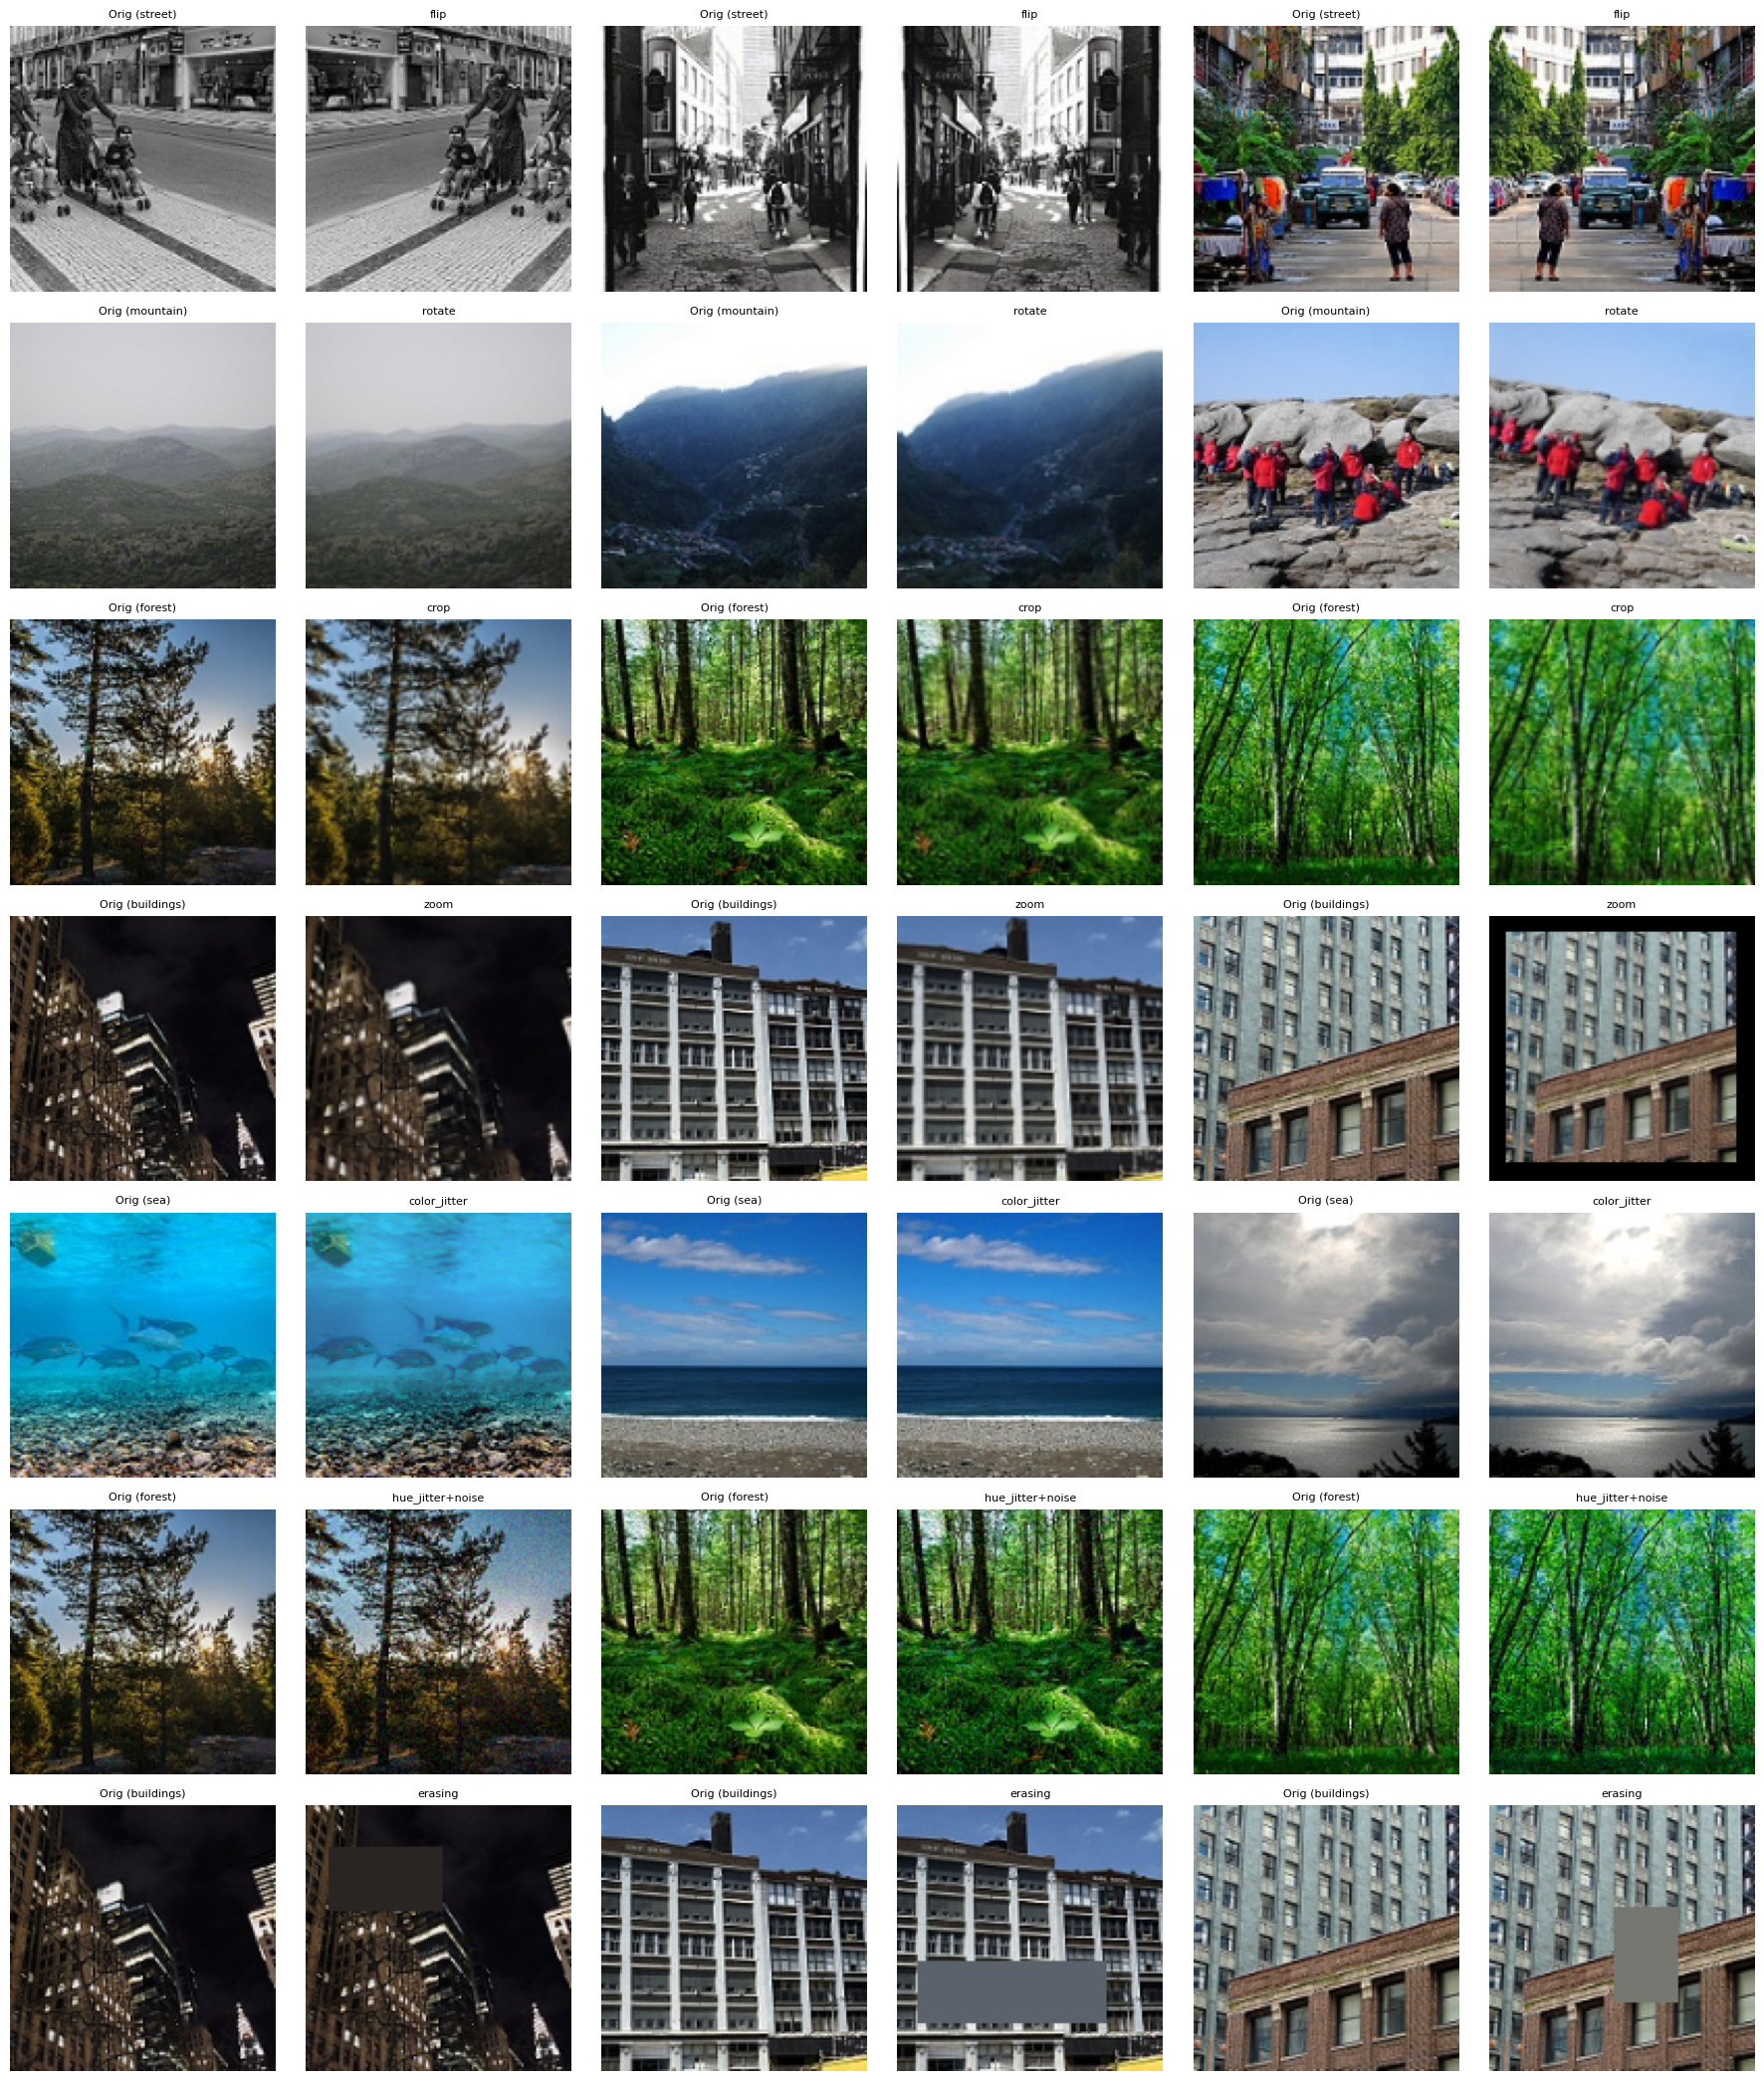

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Hvilken kategori vi vil bruke som "typisk" eksempel for hver teknikk
tech_category = {
    "flip": "street",              # gater ser bra ut speilvendt
    "rotate": "mountain",          # fjell tåler litt skjev horisont
    "crop": "forest",              # skog egner seg godt for utsnitt
    "zoom": "buildings",           # bygninger med detaljer
    "color_jitter": "sea",         # hav med lys-/kontrastvariasjon
    "hue_jitter+noise": "forest",  # masse farger og grønt
    "erasing": "buildings",        # objekter/strukturer å delvis skjule
}

techniques = [
    ("flip", lambda img: random_horizontal_flip(img)),
    ("rotate", lambda img: random_rotate(img)),
    ("crop", lambda img: random_resized_crop(img)),
    ("zoom", lambda img: random_zoom(img)),
    ("color_jitter", lambda img: random_color_jitter(img)),
    ("hue_jitter+noise", lambda img: add_gaussian_noise(random_hue_jitter(img))),
    ("erasing", lambda img: random_erasing(img)),
]

rows = len(techniques)
pairs_per_row = 3         # 3 originaler + 3 transformasjoner
cols = pairs_per_row * 2  # 3 * 2 = 6 per rad

fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))

for row, (name, func) in enumerate(techniques):
    cat_name = tech_category[name]
    idxs = np.where(train_categories == cat_name)[0]

    # hvis det finnes færre enn 3 bilder i denne kategorien (teoretisk), fyll opp med det som finnes
    if len(idxs) == 0:
        example_indices = [0] * pairs_per_row
    elif len(idxs) < pairs_per_row:
        example_indices = list(idxs) + [idxs[0]] * (pairs_per_row - len(idxs))
    else:
        # ta de tre første (evt. kunne også gjort np.random.choice)
        example_indices = idxs[:pairs_per_row]

    for i, example_idx in enumerate(example_indices):
        col_orig = 2 * i
        col_aug = 2 * i + 1

        example_img = X_train[example_idx]
        example_cat = train_categories[example_idx]

        # Original
        ax_orig = axes[row, col_orig]
        ax_orig.imshow(example_img)
        ax_orig.axis("off")
        ax_orig.set_title(f"Orig ({example_cat})", fontsize=8)

        # Transformert
        aug_img = func(example_img)
        ax_aug = axes[row, col_aug]
        ax_aug.imshow(aug_img)
        ax_aug.axis("off")
        ax_aug.set_title(f"{name}", fontsize=8)

plt.tight_layout()
plt.show()

- **Horizontal flip**  
  Horizontal flipping makes the model invariant to left–right orientation, which is natural for scene images like streets, buildings, and landscapes.

- **Small rotation**  
  Random small rotations simulate a slightly tilted camera, helping the model handle real-world images that are not perfectly aligned.

- **Random resized crop**  
  Random cropping forces the model to focus on different parts of the scene (sky, ground, objects), improving robustness to framing and composition changes.

- **Zoom in / out**  
  Zoom augmentation mimics changing the distance to the scene, teaching the model to recognize classes at different scales.

- **Color jitter (brightness / contrast / saturation)**  
  Color jitter models changes in lighting, weather, and camera exposure, so the model doesn’t overfit to a specific illumination condition.

- **Hue jitter + noise**  
  Slight hue changes and added noise simulate variations in camera sensors and color balance, making the model less sensitive to subtle color shifts and artifacts.

- **Random erasing / cutout**  
  Random erasing hides small regions of the image so the model learns to rely on multiple cues in the scene, not just one discriminative patch.


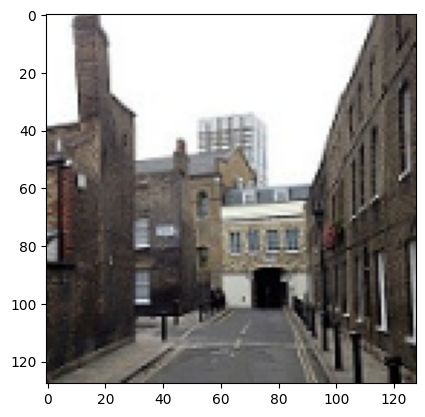

In [75]:
my_img = X_train[13000]
plt.imshow(my_img)

## Apply Canny

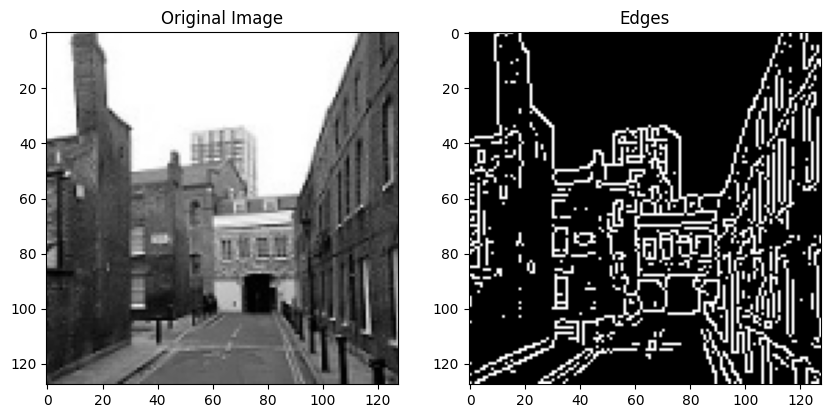

In [76]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image = cv2.cvtColor(my_img, cv2.COLOR_RGB2GRAY)

# Apply Canny edge detector
edges = cv2.Canny(image, 128, 128)

# Display the original image and the edges
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Edges')
plt.imshow(edges, cmap='gray')
plt.show()

## Apply LBP 

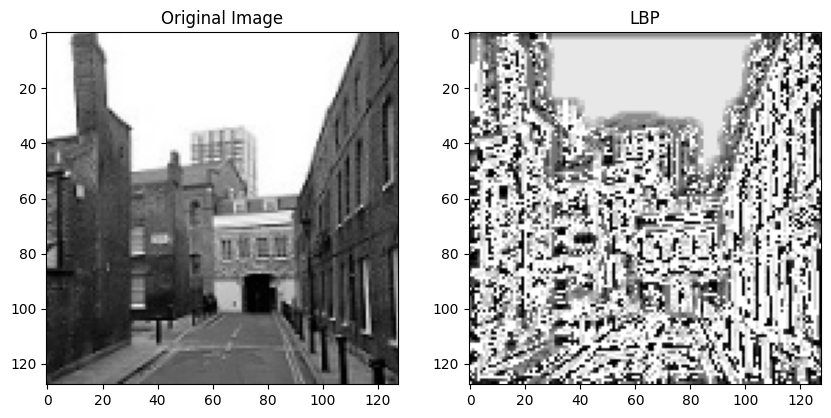

In [77]:
from skimage import io, feature
import matplotlib.pyplot as plt

# Apply Local Binary Pattern (LBP)
lbp = feature.local_binary_pattern(image, P=10, R=3, method='uniform')

# Display the original image and the LBP result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('LBP')
plt.imshow(lbp, cmap='gray')
plt.show()

## Apply HOG

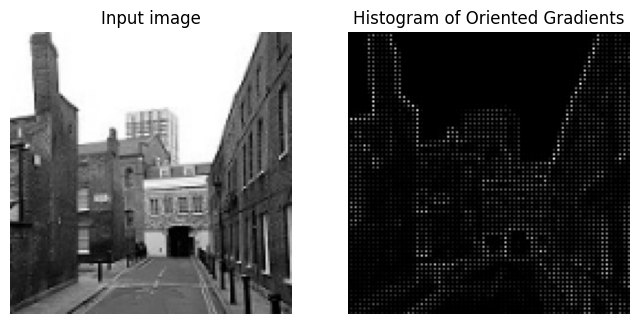

In [78]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import exposure

image = cv2.cvtColor(my_img, cv2.COLOR_RGB2GRAY)

fd, hog_image = hog(
    image,
    orientations=16,
    pixels_per_cell=(2, 2),
    cells_per_block=(8, 8),
    visualize=True,
    channel_axis=None,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
# hog_image_rescaled = exposure.rescale_intensity(hog_image)

ax2.axis('off')
ax2.imshow(hog_image, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

## Extract features from images

In [79]:
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
from tqdm import tqdm

def extract_features(batch):
    feats = []
    for img in tqdm(batch, desc="Extracting features"):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        edges = cv2.Canny(gray, 128, 128).flatten().astype(np.float32) / 255.0

        fd, _ = hog(
            gray,
            orientations=16,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=True,
            channel_axis=None,
        )

        lbp = local_binary_pattern(gray, P=10, R=3, method="uniform")
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp.max() + 2), density=True)
        
        # feats.append(np.concatenate([fd, lbp_hist, edges]))
        feats.append(np.concatenate([fd, lbp_hist]))
    return np.asarray(feats, dtype=np.float32)

X_train_feats = extract_features(X_train)
X_test_feats = extract_features(X_test)
y_train_feats = y_train.copy()
y_test_feats = y_test.copy()

Extracting features: 100%|██████████| 14019/14019 [07:50<00:00, 29.80it/s]

Extracting features: 100%|██████████| 3000/3000 [01:39<00:00, 30.24it/s]



## Basic model

In [80]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

Bruker ca 6 min (requires a lot of memory)

In [81]:

clf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [ 10, 20],
    'min_samples_split': [2, 5]
}
grid = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, verbose=1)


grid.fit(X_train_feats, y_train)
print("Best parameters found: ", grid.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/jakobnordlundby/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 170, in <module>
    exitcode = process_obj._bootstrap()
  File "/Users/jakobnordlundby/anaconda3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/jakobnordlundby/anaconda3/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._tar

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [ ]:
clf = grid.best_estimator_
clf.fit(X_train_feats, y_train)
y_pred = clf.predict(X_test_feats)
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

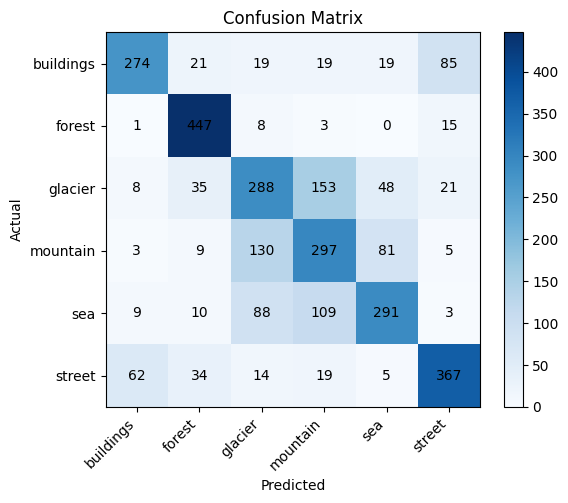

0.6546666666666666


In [ ]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap="Blues")
plt.colorbar(im, ax=ax)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_xticks(range(len(CLASS_NAMES)))
ax.set_yticks(range(len(CLASS_NAMES)))
ax.set_xticklabels(CLASS_NAMES, rotation=45, ha="right")
ax.set_yticklabels(CLASS_NAMES)
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()
print(accuracy_score(y_test, y_pred))

In [ ]:
print(accuracy_score(y_test, y_pred))

0.6546666666666666


### Advanced model